In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
import glob

In [3]:
def histoplot(var, xlabel, ylabel, bins=100, figsize=(4,4), title=""):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    h = plt.hist(var,bins)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return h[0],h[1]

In [4]:
def event_size(df):
    return len(np.unique(df.event))

In [5]:
def event_ekin(df):
    grdf = df.groupby('event')
    ekin = grdf['ekin'].sum()
    return ekin

In [6]:
def select_gammas_interact_in_crystal(df):
    grdf = df.groupby('event_id')
    return grdf.filter(lambda x: ((x.mother_id == 0) & (x['final_volume'] == 'CRYSTAL')).any() )


In [7]:
def fixdf(gdfx):
    gdf = gdfx.copy().drop(columns=['volume','primary','motherid', 'name'])
    grdf = gdf.groupby('event')
    gdfa = grdf.agg(
                etot = ('ekin', 'sum'),
                ntrk = ('ekin', 'count')).reset_index()
    
    return pd.merge(gdf, gdfa, on='event').drop(columns=['level_0','index'])

In [34]:
def fixdf_gcol(df, col):
    grdf = df.groupby('event')
    return grdf[col].first()

In [40]:
def fixdf_classify(df):
    grdf = df.groupby('event')
    return grdf.size()

In [8]:
def select_large_etot(df, ecut=0.511):
    grdf = df.groupby('event')
    return grdf.filter(lambda x: (x.etot > ecut)  )


In [9]:
def fiducial_select(df, d=48.2, z=37.2):
    df2 = df[np.abs(df['x'])<d/2]
    df3 = df2[np.abs(df2['y'])<d/2]
    df4 = df3[np.abs(df3['z'])<z/2]
    
    return df4


In [76]:
def fixdf_energy_select(df, emax=0.45):
    grouped = df.groupby('event')
    return grouped.filter(lambda x: x['etot'].max() > emax)


In [100]:
def create_ordered_df(df):
    grouped = df.groupby('event')

    # Initialize lists to store results
    results = []
    
    # Iterate over each event group
    for event_id, group in grouped:
        # Sort particles by energy in descending order
        sorted_group = group.sort_values(by='ekin', ascending=False).reset_index(drop=True)
        
        # Extract ntrak and proc from the first particle (they are the same for all particles in the event)
        event = sorted_group.loc[0, 'event']
        ntrk = sorted_group.loc[0, 'ntrk']
        proc = sorted_group.loc[0, 'proc']
        
        # Get particle with maximum energy
        x1, y1, z1, e1 = sorted_group.loc[0, ['x', 'y', 'z', 'ekin']]
        
        # Get particle with second maximum energy (if available)
        if len(sorted_group) > 1:
            x2, y2, z2, e2 = sorted_group.loc[1, ['x', 'y', 'z', 'ekin']]
        else:
            x2, y2, z2, e2 = None, None, None, None  # If no second particle, set to None
        
        # Calculate the baricenter of x1, y1, z1, e1 and x2, y2, z2, e2
        if e2 is not None:
            x12 = (x1 * e1 + x2 * e2) / (e1 + e2)
            y12 = (y1 * e1 + y2 * e2) / (e1 + e2)
            z12 = (z1 * e1 + z2 * e2) / (e1 + e2)
        else:
            x12, y12, z12 = x1, y1, z1  # If only one particle, baricenter is that particle's coordinates
        
        # Calculate the baricenter of all particles in the event
        total_energy = group['ekin'].sum()
        xb = (group['x'] * group['ekin']).sum() / total_energy
        yb = (group['y'] * group['ekin']).sum() / total_energy
        zb = (group['z'] * group['ekin']).sum() / total_energy
        
        # Append the results
        results.append({'event':event,
            'ntrk': ntrk,
            'proc': proc,
            'x1': x1, 'y1': y1, 'z1': z1, 'e1': e1,
            'x2': x2, 'y2': y2, 'z2': z2, 'e2': e2,
            'x12': x12, 'y12': y12, 'z12': z12,
            'xb': xb, 'yb': yb, 'zb': zb
        })
    
    # Create the final DataFrame
    return pd.DataFrame(results)
    


In [106]:
def xclass(df):
    phot = df[df['proc'] == "phot"]
    compt = df[df['proc'] == "compt"]
    return phot.size/df.size, compt.size/odf.size

In [109]:
def add_distances(df):
    # Calculate d12: Distance between (x1, y1, z1) and (x2, y2, z2)
    df['d12'] = np.sqrt((df['x2'] - df['x1'])**2 + (df['y2'] - df['y1'])**2 + (df['z2'] - df['z1'])**2)
    
    # Calculate d12b: Distance between (x12, y12, z12) and (xb, yb, zb)
    df['d12b'] = np.sqrt((df['xb'] - df['x12'])**2 + (df['yb'] - df['y12'])**2 + (df['zb'] - df['z12'])**2)

    return df


## CsI
- CsI crystal case. Dimensions of 48.2 x 48.2 x X0 (37.2)

In [11]:
rootdir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/CsI"
filenm = "gamma_interactions_1.csv"


In [12]:
df = pd.read_csv(f"{rootdir}/{filenm}", header=0)

In [13]:
df.head(10)

,event,trkid,name,primary,motherid,x,y,z,t,ekin,proc,volume
0,0,1,gamma,1,0,20.16540,-6.42771,-18.50000,0.000000,0.511000,Primary,CRYSTAL
1,0,2,e-,0,1,20.16540,-6.42771,-5.38180,0.043758,0.068650,compt,CRYSTAL
2,1,1,gamma,1,0,-10.12970,-19.90340,-18.50000,0.000000,0.511000,Primary,CRYSTAL
3,1,3,e-,0,1,6.64673,-12.31600,11.89240,0.124637,0.402804,phot,CRYSTAL
4,1,2,e-,0,1,-10.12970,-19.90340,-8.93121,0.031918,0.102479,compt,CRYSTAL
5,2,1,gamma,1,0,8.55399,-21.61080,-18.50000,0.000000,0.511000,Primary,CRYSTAL
6,2,4,e-,0,1,8.98611,-20.78500,14.08090,0.145484,0.087371,phot,CRYSTAL
7,2,3,e-,0,1,8.39876,-18.98350,14.35910,0.139095,0.059562,compt,CRYSTAL
8,2,2,e-,0,1,8.55399,-21.61080,18.38770,0.123044,0.330892,compt,CRYSTAL
9,3,1,gamma,1,0,1.87170,-20.91490,-18.50000,0.000000,0.511000,Primary,CRYSTAL


### Remove primary gammas and Bremsstrhalung gammas 
- Removing primary gammas also removes events in which the gamma does not interact (only secondaries)
- Removing Bremss is needed to avoid double counting

In [14]:
gdf = df[df['primary'] == 0].reset_index()

In [15]:
gdf.head(10)

,index,event,trkid,name,primary,motherid,x,y,z,t,ekin,proc,volume
0,1,0,2,e-,0,1,20.165400,-6.42771,-5.381800,0.043758,0.068650,compt,CRYSTAL
1,3,1,3,e-,0,1,6.646730,-12.31600,11.892400,0.124637,0.402804,phot,CRYSTAL
2,4,1,2,e-,0,1,-10.129700,-19.90340,-8.931210,0.031918,0.102479,compt,CRYSTAL
3,6,2,4,e-,0,1,8.986110,-20.78500,14.080900,0.145484,0.087371,phot,CRYSTAL
4,7,2,3,e-,0,1,8.398760,-18.98350,14.359100,0.139095,0.059562,compt,CRYSTAL
5,8,2,2,e-,0,1,8.553990,-21.61080,18.387700,0.123044,0.330892,compt,CRYSTAL
6,10,3,4,e-,0,1,-0.631676,-19.17010,0.903113,0.067388,0.274919,phot,CRYSTAL
7,11,3,3,e-,0,1,-0.202438,-19.46360,0.909050,0.065653,0.218864,compt,CRYSTAL
8,12,3,2,e-,0,1,1.871700,-20.91490,-10.683500,0.026073,0.011500,compt,CRYSTAL
9,14,4,3,e-,0,1,9.527290,-2.37894,-8.728490,0.044336,0.158773,phot,CRYSTAL


In [16]:
event_size(gdf)/event_size(df)

0.7852

### Bremss
- The plot below show that a few events have more than 511 keV. This is due to bremss gammas wich are double counted (since the energy of the electron that emits them is counted).

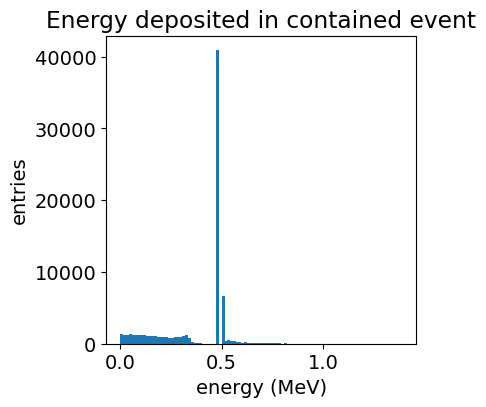

In [17]:
b, e = histoplot(event_ekin(gdf), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

### Remove Bremss
- Simply asking that particles in the df come from the primary particle will eliminate bremss photons.

In [18]:
gdf2 = gdf[gdf['motherid'] == 1].reset_index()

In [19]:
event_size(gdf2)/event_size(df)

0.7852

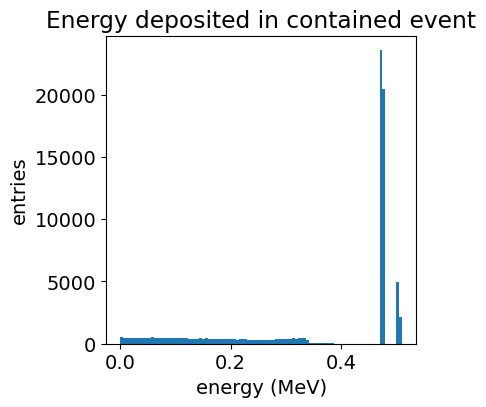

In [20]:
b, e = histoplot(event_ekin(gdf2), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

### "Fix" dataframe
- add total energy and number of particles in the event
- remove name, primary and motherid (its alwasy e-, 0 and 1)

In [22]:
gdf3 = fixdf(gdf2)

In [24]:
gdf3.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
0,0,2,20.165400,-6.42771,-5.381800,0.043758,0.068650,compt,0.068650,1
1,1,3,6.646730,-12.31600,11.892400,0.124637,0.402804,phot,0.505283,2
2,1,2,-10.129700,-19.90340,-8.931210,0.031918,0.102479,compt,0.505283,2
3,2,4,8.986110,-20.78500,14.080900,0.145484,0.087371,phot,0.477824,3
4,2,3,8.398760,-18.98350,14.359100,0.139095,0.059562,compt,0.477824,3
5,2,2,8.553990,-21.61080,18.387700,0.123044,0.330892,compt,0.477824,3
6,3,4,-0.631676,-19.17010,0.903113,0.067388,0.274919,phot,0.505283,3
7,3,3,-0.202438,-19.46360,0.909050,0.065653,0.218864,compt,0.505283,3
8,3,2,1.871700,-20.91490,-10.683500,0.026073,0.011500,compt,0.505283,3
9,4,3,9.527290,-2.37894,-8.728490,0.044336,0.158773,phot,0.475013,2


In [25]:
event_size(gdf3)/event_size(df)

0.7852

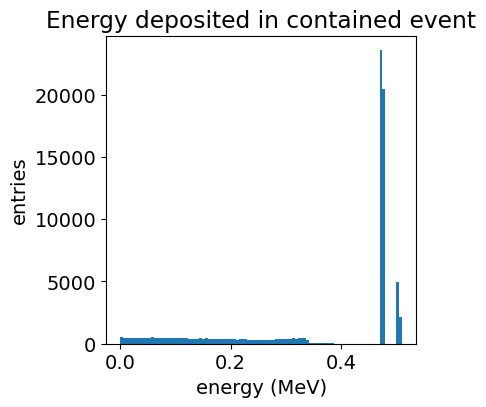

In [35]:
b, e = histoplot(fixdf_gcol(gdf3, 'etot'), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

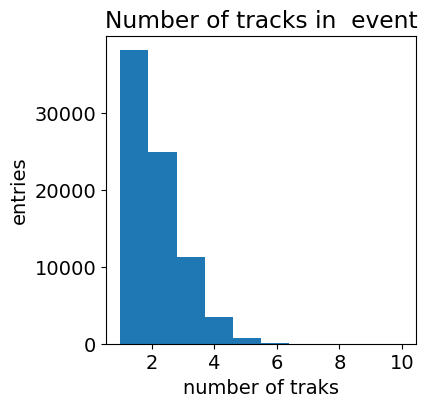

In [38]:
b, e = histoplot(fixdf_gcol(gdf3, 'ntrk'), 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Number of tracks in  event")

In [46]:
print(f" number of events with 1 particle = {b[0]/np.sum(b)}")

 number of events with 1 particle = 0.4848446255731024


In [47]:
gdf4 = fiducial_select(gdf3)

In [48]:
gdf4.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
0,0,2,20.165400,-6.42771,-5.381800,0.043758,0.068650,compt,0.068650,1
1,1,3,6.646730,-12.31600,11.892400,0.124637,0.402804,phot,0.505283,2
2,1,2,-10.129700,-19.90340,-8.931210,0.031918,0.102479,compt,0.505283,2
3,2,4,8.986110,-20.78500,14.080900,0.145484,0.087371,phot,0.477824,3
4,2,3,8.398760,-18.98350,14.359100,0.139095,0.059562,compt,0.477824,3
5,2,2,8.553990,-21.61080,18.387700,0.123044,0.330892,compt,0.477824,3
6,3,4,-0.631676,-19.17010,0.903113,0.067388,0.274919,phot,0.505283,3
7,3,3,-0.202438,-19.46360,0.909050,0.065653,0.218864,compt,0.505283,3
8,3,2,1.871700,-20.91490,-10.683500,0.026073,0.011500,compt,0.505283,3
9,4,3,9.527290,-2.37894,-8.728490,0.044336,0.158773,phot,0.475013,2


In [49]:
event_size(gdf4)/event_size(gdf3)

0.9977840040753948

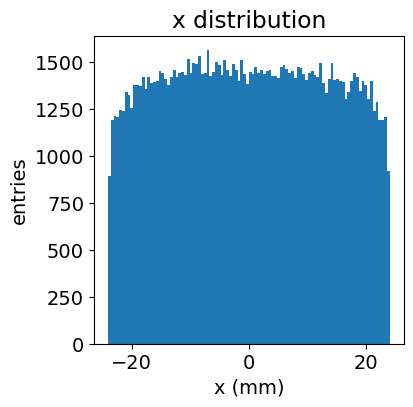

In [50]:
b, e = histoplot(gdf4.x, "x (mm)", "entries", bins=100, figsize=(4,4),
                title="x distribution")

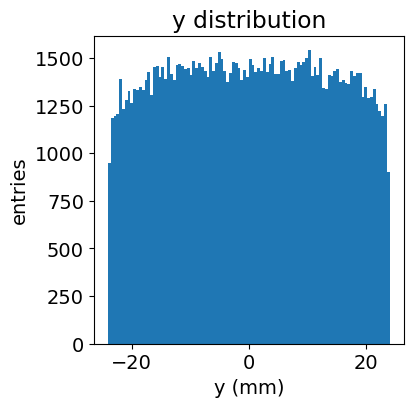

In [51]:
b, e = histoplot(gdf4.y, "y (mm)", "entries", bins=100, figsize=(4,4),
                title="y distribution")

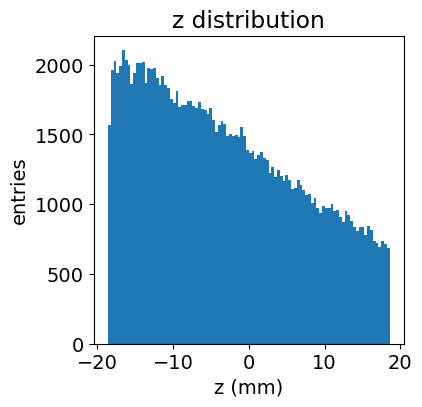

In [52]:
b, e = histoplot(gdf4.z, "z (mm)", "entries", bins=100, figsize=(4,4),
                title="z distribution")

In [53]:
gdf5 = gdf4[gdf4['ntrk']==1] # should select strictly photo and low energy compton

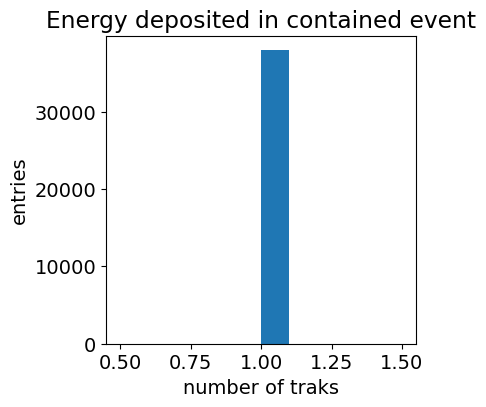

In [54]:
b, e = histoplot(gdf5.ntrk, 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Energy deposited in contained event")

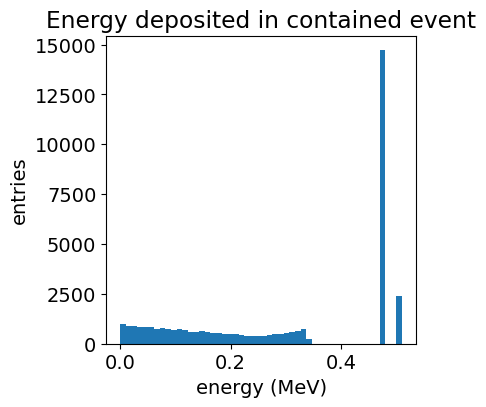

In [66]:
b, e = histoplot(event_ekin(gdf5), 'energy (MeV)', "entries", bins=50, figsize=(6,6),
                title="Energy deposited in contained event")

In [68]:
np.sum(b[40:50])/np.sum(b)

0.45109111539171964

In [77]:
photdf = fixdf_energy_select(gdf5, emax=0.45)

In [78]:
photdf

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
14,7,2,-16.384900,-22.70310,4.056870,0.075242,0.475013,phot,0.475013,1
31,17,2,-0.158071,-4.65743,-12.948200,0.018519,0.505283,phot,0.505283,1
43,24,2,9.796440,7.80851,-0.941365,0.058569,0.477824,phot,0.477824,1
44,25,2,-15.737900,3.83151,16.941400,0.118220,0.475013,phot,0.475013,1
45,26,2,11.430300,-5.79605,-1.151780,0.057867,0.475013,phot,0.475013,1
...,...,...,...,...,...,...,...,...,...,...
139946,99966,2,-18.929800,1.14442,13.734000,0.107521,0.509932,phot,0.509932,1
139951,99970,2,2.203360,-6.25147,-17.099500,0.004671,0.475013,phot,0.475013,1
139954,99972,2,6.883200,-6.98762,-17.545000,0.003185,0.475013,phot,0.475013,1
139979,99987,2,1.399150,20.13820,-0.201313,0.061038,0.477824,phot,0.477824,1


In [79]:
event_size(photdf)/event_size(df)

0.17095

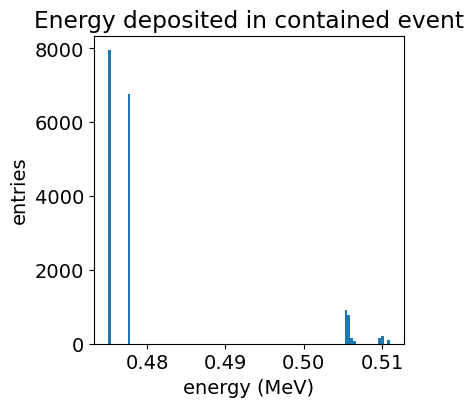

In [80]:
b, e = histoplot(event_ekin(photdf), 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

In [81]:
phlkdf = fixdf_energy_select(gdf4, emax=0.45)  # This is the fraction of events (COMPT + PE) near the peak

In [83]:
event_size(phlkdf)/event_size(df)

0.51118

In [84]:
phlkdf.head(10)

,event,trkid,x,y,z,t,ekin,proc,etot,ntrk
1,1,3,6.646730,-12.31600,11.892400,0.124637,0.402804,phot,0.505283,2
2,1,2,-10.129700,-19.90340,-8.931210,0.031918,0.102479,compt,0.505283,2
3,2,4,8.986110,-20.78500,14.080900,0.145484,0.087371,phot,0.477824,3
4,2,3,8.398760,-18.98350,14.359100,0.139095,0.059562,compt,0.477824,3
5,2,2,8.553990,-21.61080,18.387700,0.123044,0.330892,compt,0.477824,3
6,3,4,-0.631676,-19.17010,0.903113,0.067388,0.274919,phot,0.505283,3
7,3,3,-0.202438,-19.46360,0.909050,0.065653,0.218864,compt,0.505283,3
8,3,2,1.871700,-20.91490,-10.683500,0.026073,0.011500,compt,0.505283,3
9,4,3,9.527290,-2.37894,-8.728490,0.044336,0.158773,phot,0.475013,2
10,4,2,9.212210,-4.04386,-7.376290,0.037105,0.316240,compt,0.475013,2


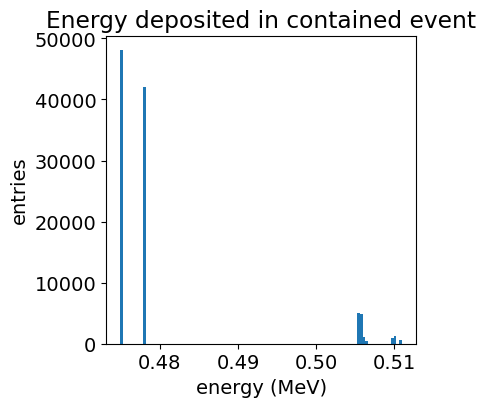

In [85]:
b, e = histoplot(phlkdf.etot, 'energy (MeV)', "entries", bins=100, figsize=(6,6),
                title="Energy deposited in contained event")

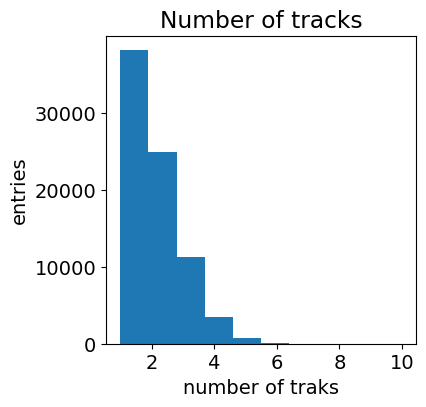

In [86]:
b, e = histoplot(fixdf_gcol(gdf3, 'ntrk'), 'number of traks', "entries", bins=10, figsize=(6,6),
                title="Number of tracks")

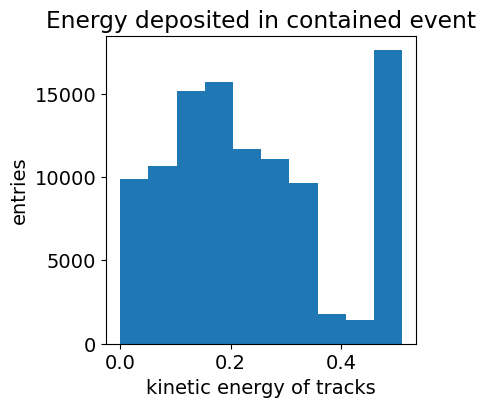

In [87]:
b, e = histoplot(phlkdf.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="Energy deposited in contained event")

In [88]:
phlk1 = phlkdf[phlkdf['ntrk']==1]

In [89]:
event_size(phlk1)/event_size(df)

0.17095

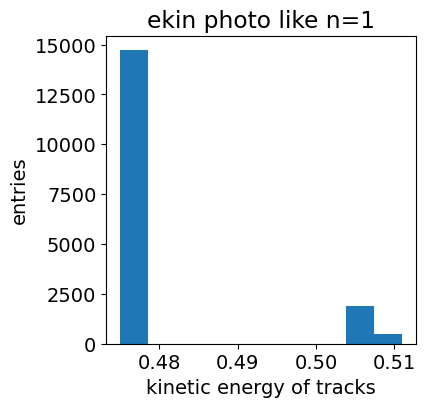

In [90]:
b, e = histoplot(phlk1.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=1")

In [91]:
phlk2 = phlkdf[phlkdf['ntrk']==2]

In [92]:
event_size(phlk2)/event_size(df)

0.19703

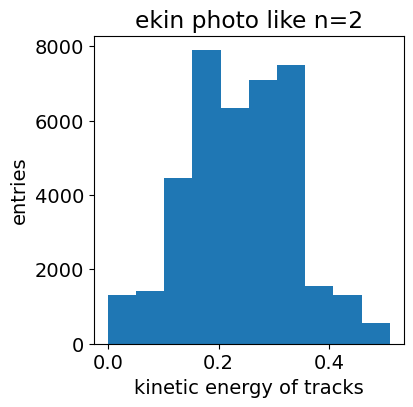

In [93]:
b, e = histoplot(phlk2.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=2")

In [94]:
phlk3 = phlkdf[phlkdf['ntrk']==3]

In [95]:
event_size(phlk3)/event_size(df)

0.10164

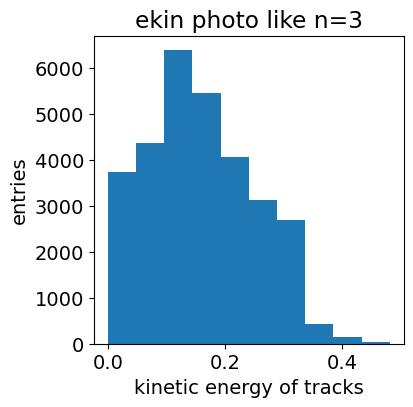

In [96]:
b, e = histoplot(phlk3.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n=3")

In [97]:
phlkn = phlkdf[phlkdf['ntrk']>3]

In [98]:
event_size(phlkn)/event_size(df)

0.04156

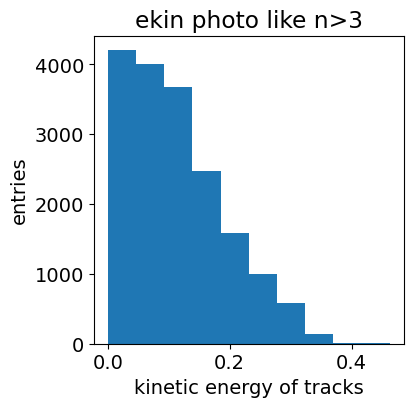

In [99]:
b, e = histoplot(phlkn.ekin, 'kinetic energy of tracks', "entries", bins=10, figsize=(6,6),
                title="ekin photo like n>3")

In [101]:
odf = create_ordered_df(phlkdf) 

In [104]:
odf

,event,ntrk,proc,x1,y1,z1,e1,x2,y2,z2,e2,x12,y12,z12,xb,yb,zb
0,1,2,phot,6.646730,-12.31600,11.892400,0.402804,-10.129700,-19.90340,-8.93121,0.102479,3.244217,-13.854839,7.669058,3.244217,-13.854839,7.669058
1,2,3,compt,8.553990,-21.61080,18.387700,0.330892,8.986110,-20.78500,14.08090,0.087371,8.644255,-21.438299,17.488056,8.613654,-21.132305,17.098027
2,3,3,phot,-0.631676,-19.17010,0.903113,0.274919,-0.202438,-19.46360,0.90905,0.218864,-0.441421,-19.300191,0.905745,-0.388776,-19.336940,0.641983
3,4,2,compt,9.212210,-4.04386,-7.376290,0.316240,9.527290,-2.37894,-8.72849,0.158773,9.317525,-3.487361,-7.828263,9.317525,-3.487361,-7.828263
4,5,3,compt,0.637559,11.49590,-12.964400,0.235772,-3.131770,8.64495,-15.65600,0.140318,-0.768766,10.432219,-13.968628,-0.004233,9.972004,-13.790436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51113,99987,1,phot,1.399150,20.13820,-0.201313,0.477824,NaN,NaN,NaN,NaN,1.399150,20.138200,-0.201313,1.399150,20.138200,-0.201313
51114,99990,2,phot,-7.542130,-8.18671,-13.392800,0.251519,-10.843000,-4.83556,-14.37850,0.226305,-9.105474,-6.599552,-13.859643,-9.105474,-6.599552,-13.859643
51115,99991,1,phot,6.460710,2.55522,2.227530,0.475013,NaN,NaN,NaN,NaN,6.460710,2.555220,2.227530,6.460710,2.555220,2.227530
51116,99992,2,phot,4.831290,8.53381,-3.763130,0.263420,12.963200,9.39977,-4.79504,0.242385,8.728153,8.948784,-4.257628,8.728153,8.948784,-4.257628


In [108]:
fp, fc = xclass(odf)
print(f"Fraction of photoelectric events with e > ecut = {fp}, of compton = {fc}")

Fraction of photoelectric events with e > ecut = 0.5780742595563206, of compton = 0.4219257404436793


In [110]:
odf = add_distances(odf)

In [112]:
odf

,event,ntrk,proc,x1,y1,z1,e1,x2,y2,z2,e2,x12,y12,z12,xb,yb,zb,d12,d12b
0,1,2,phot,6.646730,-12.31600,11.892400,0.402804,-10.129700,-19.90340,-8.93121,0.102479,3.244217,-13.854839,7.669058,3.244217,-13.854839,7.669058,27.796402,0.000000
1,2,3,compt,8.553990,-21.61080,18.387700,0.330892,8.986110,-20.78500,14.08090,0.087371,8.644255,-21.438299,17.488056,8.613654,-21.132305,17.098027,4.406495,0.496681
2,3,3,phot,-0.631676,-19.17010,0.903113,0.274919,-0.202438,-19.46360,0.90905,0.218864,-0.441421,-19.300191,0.905745,-0.388776,-19.336940,0.641983,0.520022,0.271463
3,4,2,compt,9.212210,-4.04386,-7.376290,0.316240,9.527290,-2.37894,-8.72849,0.158773,9.317525,-3.487361,-7.828263,9.317525,-3.487361,-7.828263,2.167874,0.000000
4,5,3,compt,0.637559,11.49590,-12.964400,0.235772,-3.131770,8.64495,-15.65600,0.140318,-0.768766,10.432219,-13.968628,-0.004233,9.972004,-13.790436,5.438793,0.909979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51113,99987,1,phot,1.399150,20.13820,-0.201313,0.477824,NaN,NaN,NaN,NaN,1.399150,20.138200,-0.201313,1.399150,20.138200,-0.201313,NaN,0.000000
51114,99990,2,phot,-7.542130,-8.18671,-13.392800,0.251519,-10.843000,-4.83556,-14.37850,0.226305,-9.105474,-6.599552,-13.859643,-9.105474,-6.599552,-13.859643,4.805991,0.000000
51115,99991,1,phot,6.460710,2.55522,2.227530,0.475013,NaN,NaN,NaN,NaN,6.460710,2.555220,2.227530,6.460710,2.555220,2.227530,NaN,0.000000
51116,99992,2,phot,4.831290,8.53381,-3.763130,0.263420,12.963200,9.39977,-4.79504,0.242385,8.728153,8.948784,-4.257628,8.728153,8.948784,-4.257628,8.242735,0.000000


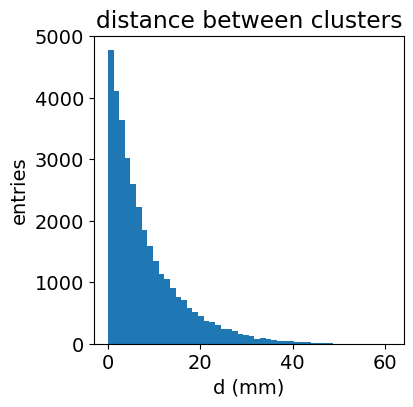

In [113]:
b, e = histoplot(odf.d12.dropna(), 'd (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between clusters")

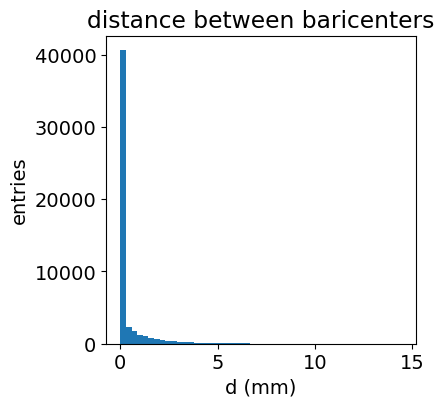

In [114]:
b, e = histoplot(odf.d12b.dropna(), 'd (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between baricenters")

In [115]:
def scatter_xyz(df):
    fig, axs = plt.subplots(2, 2, figsize=(18, 9))
    
    # Scatter plot for x1 vs x2
    axs[0,0].scatter(df['x1'], df['x2'], alpha=0.7, edgecolor='k')
    axs[0,0].set_title('Scatter plot: x1 vs x2')
    axs[0,0].set_xlabel('x1')
    axs[0,0].set_ylabel('x2')
    
    # Scatter plot for y1 vs y2
    axs[0,1].scatter(df['y1'], df['y2'], alpha=0.7, edgecolor='k')
    axs[0,1].set_title('Scatter plot: y1 vs y2')
    axs[0,1].set_xlabel('y1')
    axs[0,1].set_ylabel('y2')
    
    # Scatter plot for z1 vs z2
    axs[1,0].scatter(df['z1'], df['z2'], alpha=0.7, edgecolor='k')
    axs[1,0].set_title('Scatter plot: z1 vs z2')
    axs[1,0].set_xlabel('z1')
    axs[1,0].set_ylabel('z2')
    
    # Scatter plot for e1 vs e2
    axs[1,1].scatter(df['e1'], df['e2'], alpha=0.7, edgecolor='k')
    axs[1,1].set_title('Scatter plot: e1 vs e2')
    axs[1,1].set_xlabel('e1')
    axs[1,1].set_ylabel('e2')
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show the plots
    plt.show()


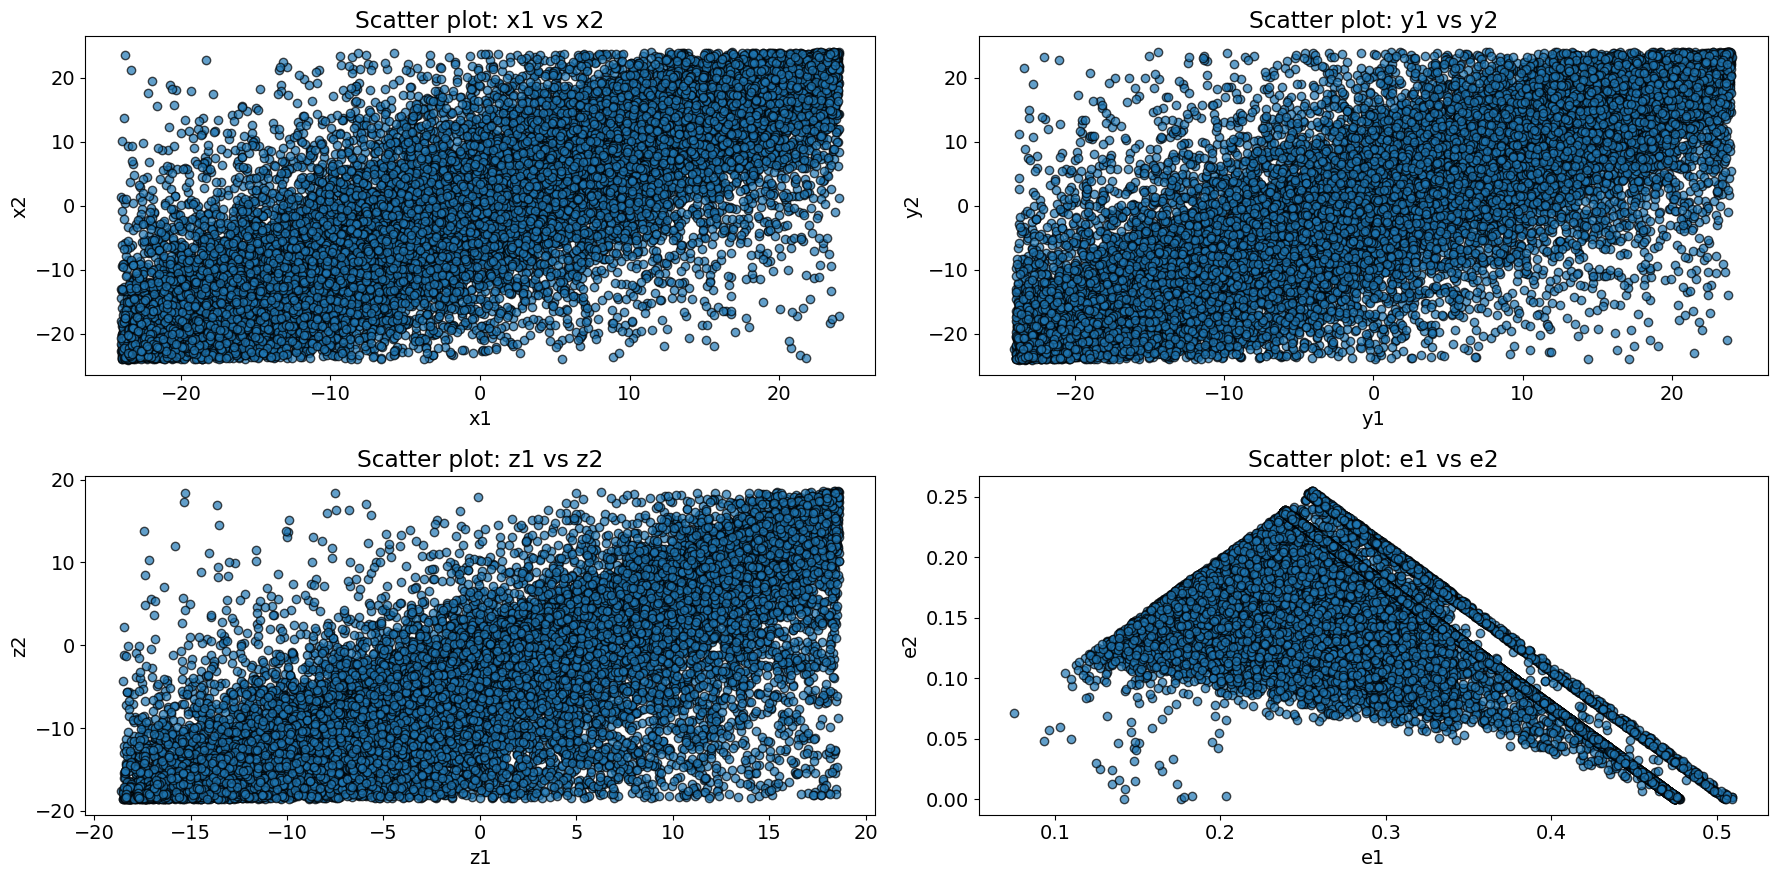

In [116]:
scatter_xyz(odf)